# Preliminary operations

Import libraries.

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
import tarfile
from shutil import copyfile

Extracting data.

In [ ]:
drive.mount('/content/gdrive', force_remount = True)
copyfile('gdrive/My Drive/DSIM/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Mounted at /content/gdrive


## Data loader

In [ ]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Feature extraction

Now, let's create the functions to extract energy, duration and zcr from each audio.

## Energy

In [ ]:
def energy(input):
  return np.sum((input*1.0)**2, keepdims=True)

## Duration

In [ ]:
def duration(input):
  return np.array(input.shape)

## Zero-crossing-rate

We have to consider the 0. If the signal goes from positive to 0 and then again becomes positive, we don't have to consider it as a zero-crossing value.

In [ ]:
def zcr(input):
  count = 0
  # Assign to prev the sign of the first value
  prev = np.sign(input[0])
  for i in range(1, input.shape[0]):
    # If the sign of the value is 0, then consider the sign of the previous value
    if np.sign(input[i]) == 0:
      succ = prev
    # Else assign to succ the sign of the value
    else:
      succ = np.sign(input[i])
    # If the two signs are different, increase the count
    if(prev != succ):
      count+=1
    # Finally, we have to update prev
    prev = succ
  return ((count, ))

## Combination

In [ ]:
def combo(input):
  return np.concatenate((energy(input), duration(input), zcr(input)))

# Only zcr

In this section, we use the zcr feature to classify our signals, through the SVM.

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = zcr)

## Hyper-parameters optimization

In [ ]:
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 100, 'gamma': 0.01}


The best values for C and gamma are, respectively, 100 and 0.01. We can try to see if there is a better combination which guarantees higher performances.

In [ ]:
param_grid = {'C': [1, 10, 100],
              'gamma': [0.00001, 0.0001, 0.001, 0.005, 0.01]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 1, 'gamma': 0.0001}


We found better values for C (1) and gamma (0.0001).

## Classification performances

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.15      0.40      0.22        10
           2       0.33      0.33      0.33        15
           3       0.40      0.11      0.17        19
           4       0.00      0.00      0.00        11
           5       0.15      0.43      0.22        14
           6       0.75      0.64      0.69        14
           7       0.33      0.11      0.16        19
           8       0.23      0.18      0.20        17
           9       0.23      0.21      0.22        14

    accuracy                           0.23       150
   macro avg       0.26      0.24      0.22       150
weighted avg       0.27      0.23      0.22       150



Through the zcr alone and the hyper-parameters optimization, we reach the 23% accuracy. Now, let's see if the combination of the features gives us better performances.

Text(0, 0.5, 'Prediction')

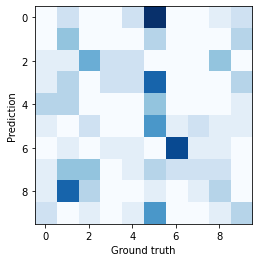

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

As we can see from the image above, the classification does not achieve high results. Moreover, the diagonal of the matrix is only slightly visible.

# Feature combination

In this section, we try another approach, combining the three features (energy, duration and zcr).

In [ ]:
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo, normalize = True)

## Hyper-parameters optimization

In [ ]:
param_grid = {'C': [100, 500, 1000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 1000, 'gamma': 0.5}


The best values for C and gamma are, respectively, 1000 and 0.05. We can try to see if there is a better combination which guarantees higher performances.

In [ ]:
param_grid = {'C': [1000, 5000, 10000],
              'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]
              }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 2)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 1000, 'gamma': 0.5}


A higher value of C does not improve the performances, so the best values are 1000 for C and 0.5 for gamma.

## Classification performances

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60        17
           1       0.35      0.80      0.48        10
           2       0.57      0.53      0.55        15
           3       0.78      0.37      0.50        19
           4       0.43      0.55      0.48        11
           5       0.41      0.50      0.45        14
           6       0.83      0.71      0.77        14
           7       0.60      0.32      0.41        19
           8       0.50      0.59      0.54        17
           9       0.56      0.71      0.63        14

    accuracy                           0.54       150
   macro avg       0.57      0.56      0.54       150
weighted avg       0.59      0.54      0.54       150



The accuracy improved (+31%), with respect to the only zcr feature.

Text(0, 0.5, 'Prediction')

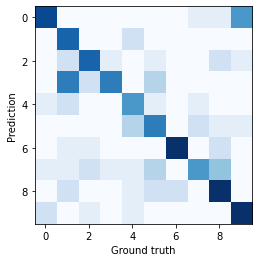

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

As we can see from the image above, performances are way better then before. Now the diagonal inside the matrix is clearly visible. However, this classification is still far from an optimal result. 